<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4). 

In [1]:
from __future__ import division, print_function
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [29]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')
PATH_TO_DATA = config['DEFAULT']['PATH_TO_DATA']
PATH_TO_TRAIN = config['DEFAULT']['PATH_TO_TRAIN']
PATH_TO_PKL = config['DEFAULT']['PATH_TO_PKL']

RSTATE = 17

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [13]:
with open(os.path.join(PATH_TO_PKL, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_PKL, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [14]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [19]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RSTATE)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [20]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [21]:
from sklearn.neighbors import KNeighborsClassifier

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [25]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')

array([ 0.57503805,  0.58249466,  0.56040268])

In [26]:
y_pred = knn.fit(X_train, y_train).predict(X_valid)
accuracy_score(y_valid, y_pred)

0.58923915619815126

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [33]:
from sklearn.ensemble import RandomForestClassifier
?RandomForestClassifier

In [30]:
forest = RandomForestClassifier(n_estimators=100, random_state=RSTATE, n_jobs=-1)
cross_val_score(forest, X_train, y_train, cv=skf, scoring='accuracy')

array([ 0.70380518,  0.71027752,  0.70805369])

In [32]:
oob_forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=RSTATE, n_jobs=-1)
cross_val_score(oob_forest, X_train, y_train, cv=skf, scoring='accuracy')

array([ 0.70380518,  0.71027752,  0.70805369])

In [34]:
y_pred = forest.fit(X_train, y_train).predict(X_valid)
accuracy_score(y_valid, y_pred)

0.72647546812040764

In [35]:
y_pred = oob_forest.fit(X_train, y_train).predict(X_valid)
accuracy_score(y_valid, y_pred)

0.72647546812040764

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
                     'answer4_2.txt')

In [ ]:
!cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [38]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
?LogisticRegression

In [37]:
logit = LogisticRegression(random_state=RSTATE, n_jobs=-1)
cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy')

C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


array([ 0.75585997,  0.77005185,  0.7580842 ])

In [39]:
y_pred = logit.fit(X_train, y_train).predict(X_valid)
accuracy_score(y_valid, y_pred)

C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.78099075610334201

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [40]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', cv=skf, random_state=RSTATE, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 20.1 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [44]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[31], axis=0)
logit_mean_cv_scores1

array([ 0.31609184,  0.47419019,  0.55354974,  0.65048004,  0.7126654 ,
        0.74873362,  0.76062195,  0.75411887,  0.74700551,  0.73603308])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [49]:
print(
    max(logit_mean_cv_scores1),
    logit_c_values1[np.argmax(logit_mean_cv_scores1)]
)

0.760621952463 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

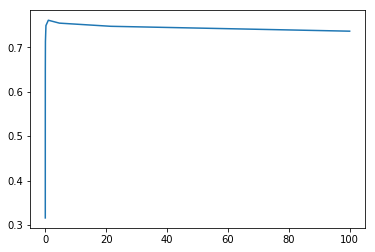

In [50]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [51]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', cv=skf, random_state=RSTATE, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 53 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [52]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[31], axis=0)
logit_mean_cv_scores2

array([ 0.75533783,  0.75574306,  0.75523484,  0.75513291,  0.75401567,
        0.75350813,  0.75310187,  0.75300021,  0.75289896,  0.75249307,
        0.75249289,  0.75249351,  0.75269688,  0.75259501,  0.75239185,
        0.75198534,  0.75188363,  0.75229028,  0.75198565,  0.75178237])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [53]:
print(
    max(logit_mean_cv_scores2),
    logit_c_values2[np.argmax(logit_mean_cv_scores2)]
)

0.75574306489 3.21052631579


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

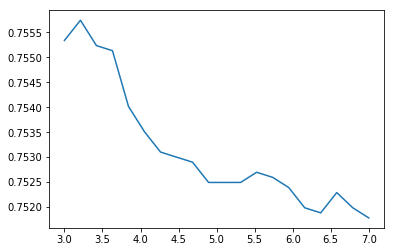

In [54]:
plt.plot(logit_c_values2, logit_mean_cv_scores2)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [56]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.77980564114719131

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [57]:
from sklearn.svm import LinearSVC
?LinearSVC

In [59]:
svm = LinearSVC(C=1, random_state=RSTATE)
cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy')

array([ 0.74581431,  0.76151266,  0.75198292])

In [60]:
y_pred = svm.fit(X_train, y_train).predict(X_valid)
accuracy_score(y_valid, y_pred)

0.77956861815596112

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [64]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 1s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [67]:
print(
    svm_grid_searcher1.best_score_,
    svm_grid_searcher1.best_params_
)

0.6975208291 {'C': 4444.4445000000005}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


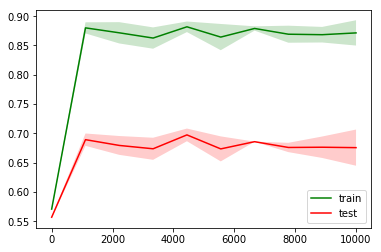

In [68]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [69]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 50s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [70]:
print(
    svm_grid_searcher2.best_score_,
    svm_grid_searcher2.best_params_
)

0.762954684007 {'C': 0.13879310344827586}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Klissan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


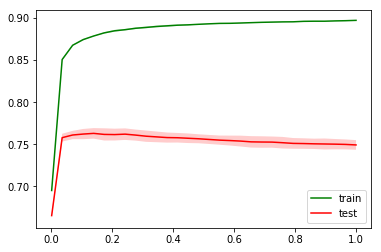

In [71]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [73]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.78644228490163548

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [74]:
''' ВАШ КОД ЗДЕСЬ '''

' ВАШ КОД ЗДЕСЬ '

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [128]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y = pickle.load(y_users_pkl)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    
    mean_cv_accuracy = cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy').mean()
    y_pred = svm.fit(X_train, y_train).predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_pred)
    
    return mean_cv_accuracy, valid_accuracy

**Убедитесь, что функция работает.**

In [129]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_PKL, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_PKL, 'y_10users.pkl'), 
                 skf, random_state=RSTATE, test_size=0.3)

(0.75310329338941384, 0.77956861815596112)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [130]:
!cp $PATH_TO_PKL/X_sparse_10users.pkl  $PATH_TO_PKL/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_PKL/X_sparse_150users.pkl $PATH_TO_PKL/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_PKL/y_10users.pkl         $PATH_TO_PKL/y_10users_s10_w10.pkl 
!cp $PATH_TO_PKL/y_150users.pkl        $PATH_TO_PKL/y_10users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [133]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_PKL, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_PKL, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        cv_score, valid_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=RSTATE)
        print('S={}, W={}  || Mean CV score = {}, Valid score = {}'
              .format(session_length, window_size, cv_score, valid_score))

S=15, W=10  || Mean CV score = 0.8077692465569349, Valid score = 0.8388243659634984
S=10, W=10  || Mean CV score = 0.7531032933894138, Valid score = 0.7795686181559611
S=15, W=7  || Mean CV score = 0.8377704133186876, Valid score = 0.8524970963995354
S=10, W=7  || Mean CV score = 0.7909707655396891, Valid score = 0.8002322880371661
S=7, W=7  || Mean CV score = 0.7474423358984907, Valid score = 0.7584204413472706
S=15, W=5  || Mean CV score = 0.8671379383964766, Valid score = 0.878615457562826
S=10, W=5  || Mean CV score = 0.8179054446536332, Valid score = 0.8296586059743954
S=7, W=5  || Mean CV score = 0.7711121854422692, Valid score = 0.7854433380749171
S=5, W=5  || Mean CV score = 0.7246233246036423, Valid score = 0.7329302987197724
Wall time: 2min 6s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [80]:
with open(os.path.join(PATH_TO_PKL, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_PKL, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [81]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [83]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[1], multi_class='ovr', random_state=RSTATE, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 8min 44s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [97]:
cv_scores_by_user = {}
for user_id, item in logit_cv_150users.scores_.items():
    cv_score = np.mean(item)
    cv_scores_by_user[user_id] = cv_score
    print('User {}, CV score: {}'.format(user_id, cv_score))

User 6, CV score: 0.9958605650477238
User 13, CV score: 0.9962258451766769
User 15, CV score: 0.9950997284037291
User 16, CV score: 0.9918679447905498
User 28, CV score: 0.9901366791652954
User 31, CV score: 0.9944846259541702
User 33, CV score: 0.9936192159328847
User 39, CV score: 0.9860811078729287
User 46, CV score: 0.9981335683872793
User 49, CV score: 0.9951312465336191
User 50, CV score: 0.9945058010884539
User 53, CV score: 0.9937653922921013
User 65, CV score: 0.9968513564862573
User 66, CV score: 0.9949225608299433
User 82, CV score: 0.996371691739771
User 85, CV score: 0.9963510716129731
User 89, CV score: 0.9906058590332121
User 92, CV score: 0.9944845785018336
User 100, CV score: 0.9947035369707043
User 102, CV score: 0.9913779946549265
User 103, CV score: 0.9807119852567698
User 105, CV score: 0.9968514175106294
User 106, CV score: 0.9945260536468785
User 118, CV score: 0.9907312602846791
User 119, CV score: 0.9966428824219093
User 120, CV score: 0.9943179195327859
User 1

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [104]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = {}
total = len(y_train_150)
for user_id in np.unique(y_train_150):
    diff = cv_scores_by_user[user_id] - (1 - float(class_distr[user_id]) / total)
    acc_diff_vs_constant[user_id] = diff
    #print(user_id, diff)
print('Mean ', np.mean(diffs))

Mean  0.00125376234806


In [106]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default / 150

0.85999999999999999

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [118]:
y_binary_128 = (y_150users == 128).astype(int)
y_binary_128

array([0, 0, 0, ..., 0, 0, 0])

In [111]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [122]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, 
                                              train_sizes=train_sizes, cv=skf,
                                              verbose = 1, random_state=RSTATE, n_jobs=-1)

[learning_curve] Training set sizes: [22836 26442 30048 33653 37259 40865 44471 48076 51682 55288 58894 62499
 66105 69711 73317 76922 80528 84134 87740 91346]
Wall time: 22.3 s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   22.0s finished


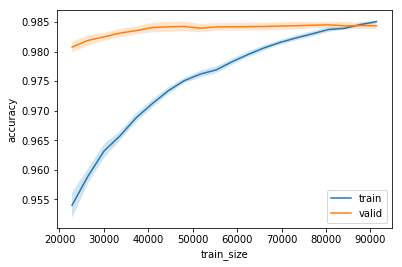

In [123]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.